# Imports and overview

This notebook implements the CORAL model from https://arxiv.org/pdf/1511.05547.pdf. It is inspired from https://github.com/SSARCandy/DeepCORAL.

In [1]:
# We can now load the dependencies
%matplotlib inline 
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 
import torchvision
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torchmetrics
import os
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from IPython.display import clear_output
import json

import sys
sys.path.append("../../Datasets/")
from Custom_Dataset import *

# Clear the cache of CUDA
torch.cuda.empty_cache()

We can start by setting a seed for reproducibility

In [2]:
torch.manual_seed(0)

For reference, here is the architecture of the model we will implement:

<img src="CORAL_architecture.png" align="center"/>

# Pre-processing

We start by defining a custom dataset which loads the data from disk lazily. This is because we have too many training examples to keep all of them in memory at once. The CustomDataset class is defined in Datasets/Cutsom_Dataset.py

In [3]:
# Extract the generated data
train_gen_dataset = CustomDataset("Generated", "train", balance = True)
val_gen_dataset = CustomDataset("Generated", "validation", balance=True)
test_gen_dataset = CustomDataset("Generated", "test", balance=True)

# Extract the real data
train_real_dataset = CustomDataset("Real Life", "train", balance=True)
val_real_dataset = CustomDataset("Real Life", "validation", balance=True)
test_real_dataset = CustomDataset("Real Life", "test", balance=True)

# Hyperparameter choices

We create a cell to hold the hyperparameters of the model

In [4]:
learning_rate_choices = {0.0005, 0.001}
batch_size = 100 # Each the real and generated data will be split into batches of this size (Since we only train on generated here)
num_epochs = 30 # Number of epochs to train for
# Choices for the gamma parameter in the focal loss
gamma_focal_loss_choices = {2, 5}
n_validation = 30 # Number of iterations between each validation run
n_validation_minibatches = 5 # Number of minibatches to use for validation
lambda_max_DA_choices = {0.1, 1, 10}  # Weight of the coral loss


# Model implementation

We can start by loading a pre-trained VGG16 model without the classification layers towards the end (Only the feature extractor).

In [5]:
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

We can now visualize its layers:

In [6]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Because we are looking for a pre-trained feature extractor here, we decide to only use the features part and freeze its weights. We can then add a few subsequent layers to fine tune predictions. We can thus define the following model:

In [7]:
class CoralModel(nn.Module):

    def __init__(self, num_classes=13):
        
        super(CoralModel, self).__init__()
        
        # Define the layers of the model
        self.features = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features
        self.classifier = nn.Sequential(
            nn.Linear(4608, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes)
        )

        # Freeze all the weights in modules 0 up-to and including 25
        for param in self.features[:25].parameters():
            param.requires_grad = False


    def forward(self, x):
        h = self.features(x)
        h = torch.flatten(h, 1)
        output = self.classifier(h)
        return h, output


# Training

We can start by finding the device to use for training:

In [8]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.has_mps:
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

if DEVICE == "cuda":
    torch.cuda.empty_cache()

print("Device:", DEVICE)

Device: mps


We can then go ahead and define the loss function we will be using. 

According to the specified model architecture, the CORAL model utilizes two loss functions. The first one is the classification loss, for whihc we will opt for a balanced focal loss rather than the regular cross-entropy loss. The aim is to assign greater importance to the classes that are more challenging to classify. The focal loss can be defined using the following formula:

$$
FL(p_t) = -(1-p_t^{\gamma})log(p_t)
$$

where gamma $\gamma$ is a tunable hyperparameter. We can also further add an alpha term to handle class imbalance, making our loss function a class-balanced focal loss, as shown in https://github.com/AdeelH/pytorch-multi-class-focal-loss. 
Note: Since we have balanced classes thanks to oversmapling, we will not use the alpha parameter.


The second loss is the Coral loss. Coral loss is a type of distance metric used to align two sets of feature representations. It stands for "correlation alignment".

The Coral loss aims to minimize the domain shift between two distributions by aligning the second-order statistics of their features. It computes the covariance matrix of the source and target features and then minimizes the Frobenius norm between the difference of the two covariance matrices. This way, the correlation between the features is preserved and domain shift is reduced.

The Coral loss can be formulated as:

$$
L_{coral}(X_s, X_t) = \lVert C_s - C_t \rVert_{F}^2
$$

where $X_s$ and $X_t$ are the source and target feature representations respectively, and $C_s$ and $C_t$ are the covariance matrices of the source and target features.

In addition to the loss function, a helper function can be defined to compute the covariance matrix:

$$
C(X) = \frac{1}{n-1}(X-\bar{X})^T(X-\bar{X})
$$

where $X$ is a matrix of feature representations and $\bar{X}$ is the mean of each feature. The following code is taken from the mentionned github repository: https://github.com/SSARCandy/DeepCORAL.

In [9]:
def CORAL_loss(source, target):

	# Number of features in the hidden representation
	d = source.data.shape[1]

    # source covariance
	xm = torch.mean(source, 0, keepdim=True) - source
	xc = xm.t() @ xm

    # target covariance
	xmt = torch.mean(target, 0, keepdim=True) - target
	xct = xmt.t() @ xmt

    # frobenius norm between source and target
	loss = torch.mean(torch.mul((xc - xct), (xc - xct)))
	loss = loss/(4*d*d)

	return loss

The total loss used in the backward step of our model is therefore represented by the following equation:

$$
TotalLoss = ClassificationLoss + \lambda DomainLoss
$$
$$
TotalLoss = FC + \lambda L_{coral}(X_s, X_t)
$$

We also adjust the hyperparameter $\lambda$, which determines the weight of the coral loss term in the total loss function." In other words, $\lambda$ controls the contribution of the coral loss to the overall loss value, with larger values of $\lambda$ giving the coral loss term more weight in the optimization process.

Finally, we need an accuracy metric to tune the hyperparameters of the model. We will opt for a balanced accuracy score, which is just regular classification accuracy but adapted to weigh each class by its frequency:

In [10]:
f1_score = torchmetrics.F1Score(task="multiclass", num_classes=13, average="weighted").to(DEVICE)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=13, average="weighted").to(DEVICE)

We can now load a single example from the loader and display its label as well as its class proportion, which should be around 1/13 which is +- 8%.

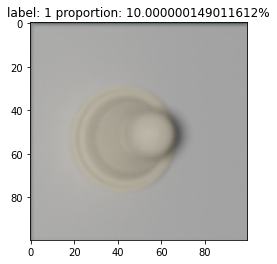

In [11]:
gen_train_loader = get_loader(train_gen_dataset, batch_size=200)

for i, (images, labels) in enumerate(gen_train_loader):
    class_proportions = [(labels == i).sum() / len(labels) for i in range(13)]
    plt.title("label: " + str(labels[0].item()) + " proportion: " + str(class_proportions[labels[0].item()].item() * 100) + "%")
    plt.imshow(images[0].permute(1, 2, 0))
    break

We can also define the following function for saving the metrics collected during training. We will plot these metrics later in the Results.ipynb file.

In [12]:
def save_metrics_to_json(training_total_losses, training_coral_losses, gen_training_classification_losses, gen_training_accs, \
                           gen_training_f1s, gen_validation_accs, gen_validation_f1s, real_validation_accs, \
                              real_validation_f1s, validation_total_losses_using_gen_classification_losses, validation_CORAL_losses, \
                                gen_validation_classification_losses, real_validation_classification_losses, real_validation_accs_full, \
                         learning_rate, lambda_max_DA, gamma_focal_loss,  batch_size, n_validation, n_validation_minibatches, num_epochs, \
                          best_real_acc, best_epoch):

    json_data = {
        "metrics": {
            "training_total_losses/iteration": training_total_losses,
            "training_coral_losses/iteration": training_coral_losses,
            "gen_training_classification_losses/iteration": gen_training_classification_losses,
            "gen_training_accs/iteration": gen_training_accs,
            "gen_training_f1s/iteration": gen_training_f1s,
            "gen_validation_accs/n_validation": gen_validation_accs,
            "gen_validation_f1s/n_validation": gen_validation_f1s,
            "real_validation_accs/n_validation": real_validation_accs,
            "real_validation_f1s/n_validation": real_validation_f1s,
            "validation_total_losses_using_gen_classification_losses/n_validation": validation_total_losses_using_gen_classification_losses,
            "validation_CORAL_losses/n_validation": validation_CORAL_losses,
            "gen_validation_classification_losses/n_validation": gen_validation_classification_losses,
            "real_validation_classification_losses/n_validation": real_validation_classification_losses,
            "real_validation_accs_full/epoch": real_validation_accs_full
        },
        "hyperparameters": {
            "learning_rate": learning_rate,
            "lambda_max_DA": lambda_max_DA,
            "gamma_focal_loss": gamma_focal_loss,
            "batch_size": batch_size,
            "n_validation": n_validation,
            "n_validation_minibatches": n_validation_minibatches,
            "num_epochs": num_epochs
        },
        "peak_performance": {
            "best_real_acc": best_real_acc,
            "best_epoch": best_epoch
        }
    }


    with open(f"HP tuning results/lr_{str(learning_rate)}_lambdacoralmax_{str(lambda_max_DA)}_gamma_{gamma_focal_loss}.json", "w") as json_file:
        json.dump(json_data, json_file)

We start by defining a function that will evaluate the model on the full validation dataset every epoch.

In [13]:
def evaluate_epoch(coralmodel, real_val_loader):

    # Set the model to eval mode
    coralmodel.eval()

    # To compute the average validation accuracy
    acc_val_sum = 0

    # Disable gradient calculation
    with torch.no_grad():

        # Iterate through the full validation set
        for X_val_real, y_val_real in real_val_loader:

            # Move the data to the device
            X_val_real = X_val_real.to(DEVICE)
            y_val_real = y_val_real.to(DEVICE)

            # Forward pass
            _, y_val_pred_prob_real = coralmodel(X_val_real)
            y_val_pred_real = torch.argmax(y_val_pred_prob_real, dim=1)

            # Compute the metrics
            acc_val_sum += accuracy(y_val_pred_real, y_val_real).item()

    # Compute the average accuracy
    average_real_acc = acc_val_sum / len(real_val_loader)

    return average_real_acc


We also define a function to check if a model was already trained and load its checkpoint if it was.

In [14]:
def check_already_trained(lambda_DA, learning_rate, gamma_focal_loss):
    if os.path.exists(f"./HP tuning results/lr_{str(learning_rate)}_lambdacoralmax_{str(lambda_DA)}_gamma_{gamma_focal_loss}.json"):
        
        # Load the json file
        with open(f"./HP tuning results/lr_{str(learning_rate)}_lambdacoralmax_{str(lambda_DA)}_gamma_{gamma_focal_loss}.json", "r") as json_file:
            json_data = json.load(json_file)
        
        # Check which epoch had the best real accuracy
        best_epoch = json_data["peak_performance"]["best_epoch"]

        # Get the corresponding real accuracy
        best_acc = json_data["peak_performance"]["best_real_acc"]

        # Find the model checkpoint corresponding to the best epoch
        best_CORAL_state_dict = torch.load(f"./checkpoints/coralmodel_lr_{str(learning_rate)}_lambdamax_{str(lambda_DA)}_gamma_{gamma_focal_loss}_epoch_{best_epoch}.ckpt")

        return best_CORAL_state_dict, best_acc
    else:
        return None, None

We can now define a training function we will call for each hyperparameter combination.

In [15]:
def train(hyperparameter_combination_number, learning_rate, lambda_max_DA, gamma_focal_loss, batch_size=batch_size, n_validation=n_validation, \
          n_validation_minibatches=n_validation_minibatches, num_epochs=num_epochs):

    # Check whether the model has already been trained
    best_CORAL_state_dict, best_acc = check_already_trained(lambda_max_DA, learning_rate, gamma_focal_loss)

    # If the model has already been trained, return it
    if best_CORAL_state_dict is not None:
        return best_CORAL_state_dict, best_acc
    
    # Define the data loaders accounting for the batch size
    gen_train_loader = get_loader(train_gen_dataset, batch_size=batch_size // 2)
    gen_val_loader = get_loader(val_gen_dataset, batch_size=batch_size // 2)
    
    real_train_loader = get_loader(train_real_dataset, batch_size=batch_size // 2)
    real_val_loader = get_loader(val_real_dataset, batch_size=batch_size // 2)

    # Define the new loss function (Taking into account gamma)
    focal_loss = torch.hub.load(
        'adeelh/pytorch-multi-class-focal-loss',
        model='FocalLoss',
        gamma=gamma_focal_loss, # No use of alpha since we have balanced classes now with the oversampling
        reduction='mean',
        force_reload=False,
        verbose = False
    ).to(DEVICE)

    # To store the training metrics every iteration
    training_total_losses = []
    training_CORAL_losses = []
    gen_training_classification_losses = []
    gen_training_accs = []
    gen_training_f1s = []

    # To store the validation metrics every n_validation iterations
    gen_validation_accs = []
    gen_validation_f1s = []
    real_validation_accs = []
    real_validation_f1s = []
    gen_validation_classification_losses = []
    real_validation_classification_losses = []
    validation_CORAL_losses = []
    validation_total_losses_using_gen_classification_loss = []

    # To store the validation accuracies every epoch
    real_validation_accs_full = []

    # Define the model and the optimizer
    coralmodel = CoralModel().to(DEVICE)
    opt = optim.Adam(coralmodel.parameters(), lr=learning_rate)

    # To keep track of the best model (Best epoch)
    best_real_acc = -1
    best_model_state_dict = None
    best_epoch = -1

    # Compute the average accuracy on the validation set at epoch 0
    average_acc = evaluate_epoch(coralmodel, real_val_loader)
    real_validation_accs_full.append(average_acc)
    
    for epoch in range(num_epochs):
        
        # Train the model
        for iteration, ((X_train_gen, y_train_gen), (X_train_real, _)) in tqdm(enumerate(zip(gen_train_loader, real_train_loader))):
            
            # Set the model to training mode
            coralmodel.train()

            # Linear progress of the training (from 0 to 1)
            p = (epoch / num_epochs + iteration / len(real_train_loader) / num_epochs)
            lamb = lambda_max_DA * p

            # Move the data to the device
            X_train_gen = X_train_gen.to(DEVICE)
            y_train_gen = y_train_gen.to(DEVICE)
            X_train_real = X_train_real.to(DEVICE)

            # Forward pass for source data (Generated data)
            hidden_rep_gen, y_train_pred_raw_gen = coralmodel(X_train_gen)
            y_train_pred_gen = torch.argmax(y_train_pred_raw_gen, dim=1)

            # Forward pass for target data (Real data)
            hidden_rep_real, y_train_pred_raw_real = coralmodel(X_train_real)

            # Compute the classification loss (Focal loss)
            gen_classification_loss_train = focal_loss(y_train_pred_raw_gen, y_train_gen.long())

            # Compute the domain loss (CORAL loss)
            coral_loss_train = (CORAL_loss(hidden_rep_gen, hidden_rep_real) + CORAL_loss(y_train_pred_raw_gen, y_train_pred_raw_real))

            # Get the total loss
            total_train_loss = gen_classification_loss_train + lamb * coral_loss_train

            # Compute the accuracy
            gen_acc_train = accuracy(y_train_pred_gen, y_train_gen)
            gen_f1_train = f1_score(y_train_pred_gen, y_train_gen)

            # Backward pass
            opt.zero_grad()
            total_train_loss.backward()
            opt.step()

            # Store the training metrics
            training_total_losses.append(total_train_loss.item())
            training_CORAL_losses.append(coral_loss_train.item())
            gen_training_classification_losses.append(gen_classification_loss_train.item())
            gen_training_accs.append(gen_acc_train.item())
            gen_training_f1s.append(gen_f1_train.item())
            
            # Check if the model should be validated
            if iteration == 0 or (iteration + 1) % n_validation == 0:
                
                # Set the model to evaluation mode
                coralmodel.eval()
                
                # Disable gradient calculation
                with torch.no_grad():

                    # Initialize variables
                    gen_acc_val_sum = 0
                    real_acc_val_sum = 0
                    gen_weighted_f1_val_sum = 0
                    real_weighted_f1_val_sum = 0
                    gen_classification_loss_val_sum = 0
                    real_classification_loss_val_sum = 0
                    total_loss_val_sum = 0
                    coral_loss_val_sum = 0

                    # Extract an iterator from the data loaders
                    gen_val_iter = iter(gen_val_loader)
                    real_val_iter = iter(real_val_loader)

                    # Iterate for n_validation_minibatches
                    for _ in range(n_validation_minibatches):

                        # Get the next minibatches
                        minibatch = next(gen_val_iter, None)
                        if minibatch is None:
                            gen_val_iter = iter(gen_val_loader)
                            minibatch = next(gen_val_iter)
                        X_val_gen, y_val_gen = minibatch

                        minibatch = next(real_val_iter, None)
                        if minibatch is None:
                            break
                        X_val_real, y_val_real = minibatch
                            
                        # Move the data to the device
                        X_val_gen = X_val_gen.to(DEVICE)
                        y_val_gen = y_val_gen.to(DEVICE)
                        X_val_real = X_val_real.to(DEVICE)
                        y_val_real = y_val_real.to(DEVICE)

                        # Forward pass for source data (Generated data)
                        hidden_rep_gen, y_val_pred_raw_gen = coralmodel(X_val_gen)
                        y_val_pred_gen = torch.argmax(y_val_pred_raw_gen, dim=1)

                        # Forward pass for target data (Real data)
                        hidden_rep_real, y_val_pred_raw_real = coralmodel(X_val_real)
                        y_val_pred_real = torch.argmax(y_val_pred_raw_real, dim=1)

                        # Compute the metrics
                        gen_classification_loss_val_sum += focal_loss(y_val_pred_raw_gen, y_val_gen.long())
                        real_classification_loss_val_sum += focal_loss(y_val_pred_raw_real, y_val_real.long())
                        coral_loss_val_sum += (CORAL_loss(hidden_rep_gen, hidden_rep_real) + CORAL_loss(y_val_pred_raw_gen, y_val_pred_raw_real))
                        total_loss_val_sum += gen_classification_loss_val_sum + lamb * coral_loss_val_sum # Only accounts for the generated classification loss as during training
                        gen_acc_val_sum += accuracy(y_val_pred_gen, y_val_gen)
                        real_acc_val_sum += accuracy(y_val_pred_real, y_val_real)
                        gen_weighted_f1_val_sum += f1_score(y_val_pred_gen, y_val_gen)
                        real_weighted_f1_val_sum += f1_score(y_val_pred_real, y_val_real)

                    # Compute the average metrics
                    gen_classification_loss_val = gen_classification_loss_val_sum / n_validation_minibatches
                    real_classification_loss_val = real_classification_loss_val_sum / n_validation_minibatches
                    coral_loss_val = coral_loss_val_sum / n_validation_minibatches
                    total_loss_val = total_loss_val_sum / n_validation_minibatches
                    gen_acc_val = gen_acc_val_sum / n_validation_minibatches
                    real_acc_val = real_acc_val_sum / n_validation_minibatches
                    gen_weighted_f1_val = gen_weighted_f1_val_sum / n_validation_minibatches
                    real_weighted_f1_val = real_weighted_f1_val_sum / n_validation_minibatches

                    # Store all metrics
                    gen_validation_classification_losses.append(gen_classification_loss_val.item())
                    real_validation_classification_losses.append(real_classification_loss_val.item())
                    validation_CORAL_losses.append(coral_loss_val.item())
                    validation_total_losses_using_gen_classification_loss.append(total_loss_val.item())
                    gen_validation_accs.append(gen_acc_val.item())
                    real_validation_accs.append(real_acc_val.item())
                    gen_validation_f1s.append(gen_weighted_f1_val.item())
                    real_validation_f1s.append(real_weighted_f1_val.item())

                    # Print an update
                    clear_output(wait=True) # Only show the last print statement
                    print('----------------------------------------------------------------')
                    print(f'TRAINING HP COMBINATION  [#{hyperparameter_combination_number}] -- EPOCH [{epoch+1}] --  ITERATION [{iteration+1}]')
                    print(f'CURRENT BEST EPOCH: {best_epoch} -- CURRENT BEST FULL VALIDATION SET ACCURACY: {best_real_acc}')
                    print('----------------------------------------------------------------')
                    print(f'TRAINING => Total_loss: {total_train_loss} -- CORAL_loss: {coral_loss_train} -- Class_loss: {gen_classification_loss_train} -- Acc_gen: {gen_acc_train} -- F1_gen: {gen_f1_train}')
                    print(f'GENERATED VALIDATION => Total_loss: {total_loss_val} -- Class_Loss: {gen_classification_loss_val} -- Acc_gen: {gen_acc_val} -- F1_gen: {gen_weighted_f1_val}')
                    print(f'REAL VALIDATION => Class_loss: {real_classification_loss_val} -- Acc_real: {real_acc_val} -- F1_real: {real_weighted_f1_val}')
                    print(f'SHARED VALIDATION => CORAL_loss: {coral_loss_val}')
                    print('----------------------------------------------------------------')

        # Save the model every epoch as a checkpoint 
        torch.save(coralmodel.state_dict(), f'./checkpoints/coralmodel_lr_{learning_rate}_lambdamax_{lambda_max_DA}_gamma_{gamma_focal_loss}_epoch_{epoch+1}.ckpt')

        # Check whether the current epoch's model is the best yet

        # Compute the average real validation accuracy of the epoch
        average_real_acc = evaluate_epoch(coralmodel, real_val_loader)

        # Append the average real validation accuracy of the epoch to the corresponding array
        real_validation_accs_full.append(average_real_acc)

        # Check whether the current version of the model is the best one
        if best_model_state_dict is None or average_real_acc > best_real_acc:
            best_real_acc = average_real_acc
            best_model_state_dict = coralmodel.state_dict()
            best_epoch = epoch + 1

    # Plot and save the metrics
    save_metrics_to_json(training_total_losses, training_CORAL_losses, gen_training_classification_losses,\
                        gen_training_accs, gen_training_f1s, gen_validation_accs, gen_validation_f1s, \
                        real_validation_accs, real_validation_f1s, validation_total_losses_using_gen_classification_loss, \
                        validation_CORAL_losses, gen_validation_classification_losses, real_validation_classification_losses, \
                        real_validation_accs_full, learning_rate, lambda_max_DA, gamma_focal_loss, batch_size, n_validation, \
                        n_validation_minibatches, num_epochs, best_real_acc, best_epoch)

    return  best_model_state_dict, best_real_acc

We can now proceed to train and evaluate our model:

In [16]:
# To store the best model
best_real_acc = -1

# Store the validation accuracies
hp_final_accs = pd.DataFrame(columns=["Lambda max (DA factor)", "Learning Rate",  "Gamma (focal loss)", "Best Validation Accuracy"])

# To keep track of the number of models trained
model_count = 1

for gamma_focal_loss in gamma_focal_loss_choices:

    for learning_rate in learning_rate_choices:

        for lambda_max_DA in lambda_max_DA_choices:

            # Train the model
            cur_best_model_state_dict, cur_best_real_acc = train(model_count, learning_rate, lambda_max_DA, gamma_focal_loss)

            # Create a row to add to the dataframe
            row = [lambda_max_DA, learning_rate, gamma_focal_loss, cur_best_real_acc]

            # Store it
            hp_final_accs.loc[len(hp_final_accs)] = row

            # Compare to the best model
            if cur_best_real_acc > best_real_acc:
                best_real_acc = cur_best_real_acc
                torch.save(cur_best_model_state_dict, f'./best_CORAL_model.ckpt')

            # Save (overwrite) the dataframe as a table every time a model finish training so that we can keep track of the progress
            hp_final_accs.to_csv('./HP_best_real_accuracy_comparison_table.csv', index=False)

            # Increment the model count
            model_count += 1


510it [02:23,  1.71it/s]

----------------------------------------------------------------
TRAINING HP COMBINATION  [#12] -- EPOCH [30] --  ITERATION [510]
CURRENT BEST EPOCH: 14 -- CURRENT BEST FULL VALIDATION SET ACCURACY: 0.8440624885261059
----------------------------------------------------------------
TRAINING => Total_loss: 0.1721600890159607 -- CORAL_loss: 0.008688914589583874 -- Class_loss: 0.085287906229496 -- Acc_gen: 1.0 -- F1_gen: 1.0
GENERATED VALIDATION => Total_loss: 0.49998965859413147 -- Class_Loss: 0.08903801441192627 -- Acc_gen: 1.0 -- F1_gen: 1.0
REAL VALIDATION => Class_loss: 0.43654507398605347 -- Acc_real: 0.8359999656677246 -- F1_real: 0.8300384283065796
SHARED VALIDATION => CORAL_loss: 0.008380119688808918
----------------------------------------------------------------


512it [02:23,  3.56it/s]


After this code runs, the best model can be found in the directory of the script.